In [1]:
import tensorflow as tf
import PIL.Image
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, Flatten, MaxPooling2D, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import Loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.losses import GIoULoss
import os
from tqdm import tqdm
import skimage
import skimage.io

In [44]:
def generate_coordinates( id_img, k_js, xyz_js ):
    coords_1 = np.matmul( k_js[ id_img ], xyz_js.T).T
    uv_1 = coords_1[:, :2]/coords_1[:, -1:]
    uv_1 = np.round(uv_1).astype('int')
    return uv_1

def generate_labeled_image( im_1, uv_1 ):
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19,20]]
    
    colors_vertex = [ (0,0,0), (0,200,100), (50,50,250), (200,0,0), (255,255,50), (0,100,100), (100,170,255),
                      (255,50,150), (130,130,60),(150,250,50), (10,130,200), (190,0,70),  (220,180, 0), (20,100,40), 
                      (60,10,150), (140,0,40), (240,160,0), (0,200,160),  (90,100,170), (150,0,70),(220,200,70)]
    
    for c in connections:
        im_1 = cv2.line( im_1, uv_1[c[0]], uv_1[c[1]], (255,255,255), 2)
    for p_i, point in enumerate(uv_1):
        im_1 = cv2.circle( im_1, point, 2, colors_vertex[ p_i ], -1)
    return im_1

def load_training_data( image_list, xyz_js, k_js, images_path, num_max_samples, image_size ):
    X_images = []
    Y_coords = []
    Ids_samples = [] 
    for img_name in image_list[:num_max_samples]:
        id_img = int(img_name.split('.')[0])
        if id_img < len(xyz_js):
            try:
                ###im_1 = cv2.resize( cv2.imread( images_path + img_name ), image_size )
                im_1 = cv2.imread( images_path + img_name )
                ###X_images.append( im_1 )
                Ids_samples.append( id_img )
                pxy = generate_coordinates( id_img, k_js, xyz_js[ id_img ] )

                y_arr = np.zeros( ( im_1.shape[0], im_1.shape[1], 21 ) )
                for i in range( len(pxy) ):
                    y_target_map = np.zeros( (im_1.shape[0], im_1.shape[1]) )
                    y_target_map[ pxy[i, 1], pxy[i, 0] ] = 1
                    y_target_map = cv2.GaussianBlur( y_target_map, (9,9), sigmaX = 2, sigmaY = 2 )
                    y_target_map[ y_target_map > 0] = 1
                    #y_target_map = y_target_map/y_target_map.max()

                    y_arr[ :,:,i ] = y_target_map
                    
                im_1 = cv2.resize( im_1, image_size )
                y_arr = cv2.resize( y_arr, image_size )
                
                Y_coords.append( y_arr )
                X_images.append( im_1 )
                
            except Exception as e:
                print(e)

    X_images = np.array( X_images )/255
    Y_coords = np.array( Y_coords  )
    return X_images, Y_coords, Ids_samples

In [40]:
def hand_pose_model( input_shape, list_filter_size ):
    """
    Model that reduces shape with filters and then upsamples.
    """
    reduction_blocks = len( list_filter_size )
    input_x = Input( shape = input_shape, name = 'input_layer' )
    x = BatchNormalization( name = 'batchnnorm_input' )( input_x )
    inner_layer = 0
    
    # Reduction blocks:
    for redblock_i in range( reduction_blocks ):
        x = Dropout( 0.7, name = f'rb{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'rb{redblock_i}_conv_{inner_layer}' )( x )
        inner_layer = inner_layer + 1
        x = BatchNormalization( name = f'rb{redblock_i}_batchnnorm_{redblock_i}' )( x )
        x = Dropout( 0.7, name = f'rb{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'rb{redblock_i}_conv_{inner_layer}' )( x )
        if ( redblock_i < reduction_blocks-1 ):
            x = MaxPooling2D( pool_size = (2, 2), name = f'rb{redblock_i}_maxpool_{redblock_i}' )( x )
        inner_layer = inner_layer + 1
        
    
    list_filter_size = list_filter_size[::-1]
    
    x = UpSampling2D( size = (2, 2), name = f'upsample_{0}' )( x )
    
    # Expansion blocks:
    for redblock_i in range( reduction_blocks-1 ):
        x = Dropout( 0.7, name = f'ub{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'ub{redblock_i}_conv_{inner_layer}' )( x )
        inner_layer = inner_layer + 1
        x = BatchNormalization( name = f'ub{redblock_i}_batchnnorm_{redblock_i+reduction_blocks}' )( x )
        x = Dropout( 0.7, name = f'ub{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'ub{redblock_i}_conv_{inner_layer}' )( x )
        if ( redblock_i < reduction_blocks-2 ):
            x = UpSampling2D( size = (2, 2), name = f'ub{redblock_i}_upsample_{redblock_i+reduction_blocks}' )( x )
        inner_layer = inner_layer + 1
        
    # Output layer:
    y_hat = Conv2D( filters = 21, kernel_size = 3, padding = 'same', strides = 1,
                    activation = 'sigmoid', name = 'conv_out' )( x )
    
    
    model = Model( inputs = input_x, outputs = y_hat, name = 'hand_pose_model' )
    
    return model       

def hand_pose_model( input_shape, list_filter_size ):
    """
    U-Net (encoder-decoder) Model that reduces shape with filters and then upsamples with shortcuts.
    """
    reduction_blocks = len( list_filter_size )
    input_x = Input( shape = input_shape, name = 'input_layer' )
    x = BatchNormalization( name = 'batchnnorm_input' )( input_x )
    inner_layer = 0
    
    shortcut_layers = [] 
    
    # Reduction blocks:
    for redblock_i in range( reduction_blocks ):
        x = Dropout( 0.7, name = f'rb{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'rb{redblock_i}_conv_{inner_layer}' )( x )
        inner_layer = inner_layer + 1
        x = BatchNormalization( name = f'rb{redblock_i}_batchnnorm_{redblock_i}' )( x )
        x = Dropout( 0.7, name = f'rb{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'rb{redblock_i}_conv_{inner_layer}' )( x )
        if ( redblock_i < reduction_blocks-1 ):
            x = MaxPooling2D( pool_size = (2, 2), name = f'rb{redblock_i}_maxpool_{redblock_i}' )( x )
        inner_layer = inner_layer + 1
        shortcut_layers.append( x )
        
    
    list_filter_size = list_filter_size[::-1]
    shortcut_layers = shortcut_layers[::-1]
    
    
    x = UpSampling2D( size = (2, 2), name = f'upsample_{0}' )( x )
    
    
    # Expansion blocks:
    for redblock_i in range(  reduction_blocks-2 ):
        
        x = concatenate( [ shortcut_layers[redblock_i+2], x ], axis = 3 )
        
        x = Dropout( 0.7, name = f'ub{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'ub{redblock_i}_conv_{inner_layer}' )( x )
        inner_layer = inner_layer + 1
        x = BatchNormalization( name = f'ub{redblock_i}_batchnnorm_{redblock_i+reduction_blocks}' )( x )
        x = Dropout( 0.7, name = f'ub{redblock_i}_dropout_{inner_layer}' )( x )
        x = Conv2D( filters = list_filter_size[ redblock_i ], kernel_size = 3, padding = 'same',
                    strides = 1, activation = 'relu', name = f'ub{redblock_i}_conv_{inner_layer}' )( x )
        if ( redblock_i < reduction_blocks-2 ):
            x = UpSampling2D( size = (2, 2), name = f'ub{redblock_i}_upsample_{redblock_i+reduction_blocks}' )( x )
        inner_layer = inner_layer + 1
        
        
        
    # Output layer:
    y_hat = Conv2D( filters = 21, kernel_size = 3, padding = 'same', strides = 1,
                    activation = 'sigmoid', name = 'conv_out' )( x )
    
    
    model = Model( inputs = input_x, outputs = y_hat, name = 'hand_pose_model' )
    
    return model   


class IOULoss( Loss ):
    def call( self, y_true, y_pred ):
        intersect_y = tf.reduce_sum( tf.multiply(y_true, y_pred) )
        union_y = tf.reduce_sum( tf.square(y_true) + tf.square(y_pred) - intersect_y )
        return intersect_y/union_y


In [37]:
#mano_js = json.load( open('archive-3/training_mano.json') )
#verts_js = json.load( open('archive-3/training_verts.json') )
k_js = np.array( json.load( open('archive-3/training_K.json') ) )
scale_js = json.load( open('archive-3/training_scale.json') )
xyz_js = np.array( json.load( open('archive-3/training_xyz.json') ) )
train_images_path = "archive-3/training/rgb/"
train_images_list = os.listdir( train_images_path )

In [ ]:
num_max_samples = 10000
image_size = (128,128)###(224, 224)
x_train, y_train, ids_train = load_training_data( train_images_list, xyz_js, k_js, train_images_path,
                                      num_max_samples, image_size )

index 227 is out of bounds for axis 0 with size 224


In [196]:
x_train.shape, y_train.shape

((2510, 128, 128, 3), (2510, 128, 128, 21))

In [238]:
input_shape = (image_size[0], image_size[1], 3) #(224, 224, 3)
list_filter_sizes = [8, 16, 32, 64, 128]##[16, 32, 64, 128]
cnn_model = hand_pose_model( input_shape, list_filter_sizes )

In [239]:
cnn_model.summary()

Model: "hand_pose_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 batchnnorm_input (BatchNormali  (None, 128, 128, 3)  12         ['input_layer[0][0]']            
 zation)                                                                                          
                                                                                                  
 rb0_dropout_0 (Dropout)        (None, 128, 128, 3)  0           ['batchnnorm_input[0][0]']       
                                                                                    

In [240]:
plot_model( cnn_model, show_shapes = True )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [241]:
cnn_model.compile( optimizer = tf.keras.optimizers.Adam(0.001),
                   loss = 'mean_squared_error', metrics = 'mean_absolute_error' )
#cnn_model.compile( optimizer = tf.keras.optimizers.Adam(0.0001), loss = IOULoss() )

In [201]:
training_history = cnn_model.fit( x_train, y_train, batch_size = 64, epochs = 20, validation_split = 0.3 )

Epoch 1/100


2022-08-28 09:26:05.879134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1399 - mean_absolute_error: 0.3152

2022-08-28 09:26:16.326767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 13s 418ms/step - loss: 0.1399 - mean_absolute_error: 0.3152 - val_loss: 0.0392 - val_mean_absolute_error: 0.1796
Epoch 2/100
28/28 [==============================] - 9s 325ms/step - loss: 0.0143 - mean_absolute_error: 0.0682 - val_loss: 0.0031 - val_mean_absolute_error: 0.0317
Epoch 3/100
28/28 [==============================] - 9s 322ms/step - loss: 0.0041 - mean_absolute_error: 0.0293 - val_loss: 0.0019 - val_mean_absolute_error: 0.0125
Epoch 4/100
28/28 [==============================] - 9s 322ms/step - loss: 0.0028 - mean_absolute_error: 0.0196 - val_loss: 0.0017 - val_mean_absolute_error: 0.0065
Epoch 5/100
28/28 [==============================] - 9s 325ms/step - loss: 0.0023 - mean_absolute_error: 0.0146 - val_loss: 0.0016 - val_mean_absolute_error: 0.0044
Epoch 6/100
28/28 [==============================] - 9s 325ms/step - loss: 0.0021 - mean_absolute_error: 0.0114 - val_loss: 0.0015 - val_mean_absolute_error: 0.0034
Epoch 7/100
28/28 [==

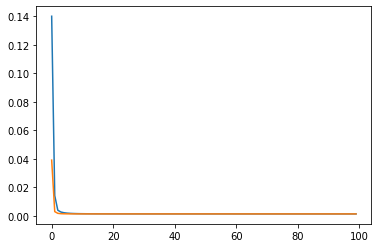

In [203]:
plt.plot( training_history.history['loss'] )
plt.plot( training_history.history['val_loss'] )
#plt.yscale('log')

In [60]:
k_js_test =  k_js.copy()

In [204]:
dat_id = 22
id_img = ids_train[dat_id]
print(id_img)
test_img_name = f'archive-3/training/rgb/000{id_img}.jpg'

id_img_test = int(test_img_name.split('.')[0].split('/')[-1])
im_test = cv2.imread( test_img_name )/255
pxy = generate_coordinates( id_img, k_js, xyz_js[ id_img ] )
im_test = generate_labeled_image( im_test, pxy )
im_test = cv2.resize( im_test, image_size )
im_test_1 = np.array( [im_test] )
y_map = y_train[ dat_id ]

29910


In [232]:
map_predicted = cnn_model.predict( im_test_1 )

1/1 [==============================] - 0s 30ms/step


In [233]:
#map_predicted[ map_predicted >0.05 ] = 1
#map_predicted[ map_predicted <= 0.05 ] = 0

In [234]:
map_predicted.shape

(1, 128, 128, 21)

In [235]:
map_predicted[0,:,:,0].max()

0.048897605

In [236]:
map_predicted[0,:,:,0]

array([[4.8897605e-02, 1.6557339e-03, 1.1285639e-03, ..., 3.5435878e-04,
        5.3889240e-04, 7.2540543e-03],
       [1.1382530e-03, 3.3086385e-06, 1.0101057e-06, ..., 1.7669331e-07,
        6.5678068e-07, 1.1468377e-04],
       [8.0961059e-04, 1.3862615e-06, 4.0503733e-07, ..., 4.2074969e-08,
        2.0856699e-07, 5.2043721e-05],
       ...,
       [2.0283749e-03, 1.4674958e-05, 5.8741111e-06, ..., 2.0280920e-08,
        7.3714041e-08, 3.0601448e-05],
       [2.6581651e-03, 2.6906493e-05, 1.0554110e-05, ..., 6.3252976e-08,
        2.3755328e-07, 7.6107259e-05],
       [2.2317203e-02, 1.4756019e-03, 7.1409618e-04, ..., 3.1157739e-05,
        1.0099119e-04, 3.2835633e-03]], dtype=float32)

In [228]:
np.where( map_predicted[0,:,:,0] == map_predicted[0,:,:,0].max() )

(array([  0,   0,   0, ..., 127, 127, 127]),
 array([  0,   1,   2, ..., 125, 126, 127]))

In [229]:
np.argmax( map_predicted[0,:,:,0],  ) 

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


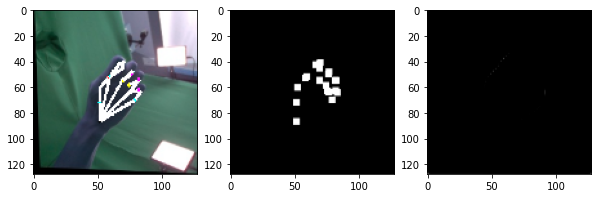

In [237]:
fig_1 = plt.figure( figsize = (10,6) )
ax_i = fig_1.add_subplot( 1, 3, 1 )
ax_i.imshow( im_test_1[0] )
ax_i = fig_1.add_subplot( 1, 3, 2 )
ax_i.imshow( np.sum(y_map, axis = 2).clip(0,1), cmap = 'gray' )
ax_i = fig_1.add_subplot( 1, 3, 3 )
ax_i.imshow( np.sum( map_predicted[0], axis = 2 ), cmap = 'gray' )
#ax_i.imshow( np.sum( cv2.GaussianBlur( map_predicted[0]/np.max(map_predicted[0], axis = (0,1) ),
#                                       (9,9), sigmaX = 2, sigmaY = 2 ), axis = 2), cmap = 'gray' )

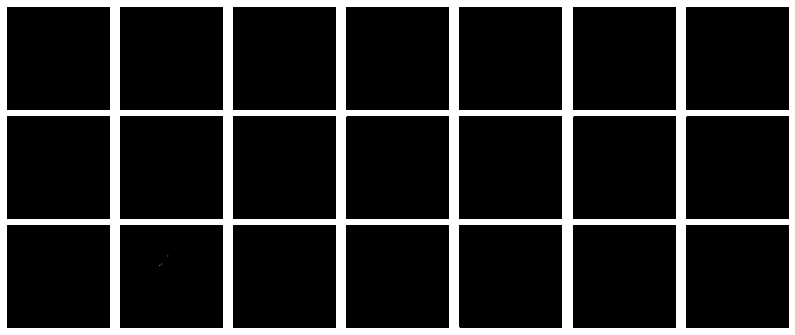

In [231]:
fig_1 = plt.figure( figsize = (14,6) )
for i in range(21):
    ax_i = fig_1.add_subplot( 3, 7, i+1 )
    ax_i.imshow( map_predicted[0,:,:,i], cmap = 'gray' )
    ax_i.axis('off')
fig_1.subplots_adjust(wspace=0.1, hspace=0.01)

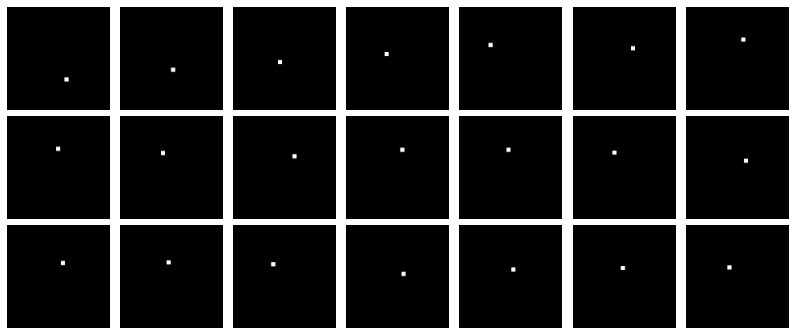

In [178]:
fig_1 = plt.figure( figsize = (14,6) )
for i in range(21):
    ax_i = fig_1.add_subplot( 3, 7, i+1 )
    ax_i.imshow( y_train[0,:,:,i], cmap = 'gray' )
    ax_i.axis('off')
fig_1.subplots_adjust(wspace=0.1, hspace=0.01)

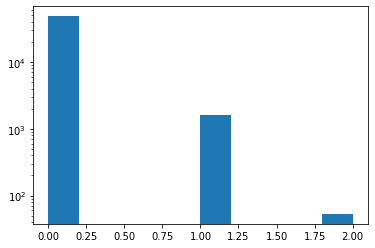

In [508]:
plt.hist(np.sum(y_map, axis = 2).reshape(-1,1))
plt.yscale('log')